In [1]:
import argparse
import logging
import math
import os
import random

import datasets
from datasets import load_dataset, load_metric
from torch.utils.data.dataloader import DataLoader
from tqdm.auto import tqdm

import transformers
from accelerate import Accelerator
from transformers import (
    AdamW,
    AutoConfig,
    AutoModelForSequenceClassification,
    AutoTokenizer,
    DataCollatorWithPadding,
    PretrainedConfig,
    SchedulerType,
    default_data_collator,
    get_scheduler,
    set_seed,
)
from transformers.utils.versions import require_version

# My custom model
from models import BertForSequenceClassification
from models import BertConfig
import torch
import matplotlib.pyplot as plt

In [2]:
logger = logging.getLogger(__name__)

In [3]:
task_to_keys = {
    "cola": ("sentence", None),
    "mnli": ("premise", "hypothesis"),
    "mrpc": ("sentence1", "sentence2"),
    "qnli": ("question", "sentence"),
    "qqp": ("question1", "question2"),
    "rte": ("sentence1", "sentence2"),
    "sst2": ("sentence", None),
    "stsb": ("sentence1", "sentence2"),
    "wnli": ("sentence1", "sentence2"),
}

In [33]:
# constant
seed = None
task_name = "mrpc"
pad_to_max_length = True
per_device_eval_batch_size = 8
max_length = 128
save_layers_attention = True

In [5]:
accelerator = Accelerator()

In [8]:
if seed is not None:
    set_seed(seed)

In [9]:
if task_name is not None:
    # Downloading and loading a dataset from the hub.
    raw_datasets = load_dataset("glue", task_name)

if task_name is not None:
    is_regression = task_name == "stsb"
    if not is_regression:
        label_list = raw_datasets["train"].features["label"].names
        num_labels = len(label_list)
    else:
        num_labels = 1
else:
    # Trying to have good defaults here, don't hesitate to tweak to your needs.
    is_regression = raw_datasets["train"].features["label"].dtype in ["float32", "float64"]
    if is_regression:
        num_labels = 1
    else:
        # A useful fast method:
        # https://huggingface.co/docs/datasets/package_reference/main_classes.html#datasets.Dataset.unique
        label_list = raw_datasets["train"].unique("label")
        label_list.sort()  # Let's sort it for determinism
        num_labels = len(label_list)

Reusing dataset glue (/home/hkab/.cache/huggingface/datasets/glue/mrpc/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


  0%|          | 0/3 [00:00<?, ?it/s]

In [14]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

In [15]:
# tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
# change model pretrained path here
model = BertForSequenceClassification.from_pretrained("bert-base-uncased")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [11]:
# Preprocessing the datasets
if task_name is not None:
    sentence1_key, sentence2_key = task_to_keys[task_name]
else:
    # Again, we try to have some nice defaults but don't hesitate to tweak to your use case.
    non_label_column_names = [name for name in raw_datasets["train"].column_names if name != "label"]
    if "sentence1" in non_label_column_names and "sentence2" in non_label_column_names:
        sentence1_key, sentence2_key = "sentence1", "sentence2"
    else:
        if len(non_label_column_names) >= 2:
            sentence1_key, sentence2_key = non_label_column_names[:2]
        else:
            sentence1_key, sentence2_key = non_label_column_names[0], None

In [12]:
# Some models have set the order of the labels to use, so let's make sure we do use it.
label_to_id = None
if (
    model.config.label2id != PretrainedConfig(num_labels=num_labels).label2id
    and task_name is not None
    and not is_regression
):
    # Some have all caps in their config, some don't.
    label_name_to_id = {k.lower(): v for k, v in model.config.label2id.items()}
    if list(sorted(label_name_to_id.keys())) == list(sorted(label_list)):
        logger.info(
            f"The configuration of the model provided the following label correspondence: {label_name_to_id}. "
            "Using it!"
        )
        label_to_id = {i: label_name_to_id[label_list[i]] for i in range(num_labels)}
    else:
        logger.warning(
            "Your model seems to have been trained with labels, but they don't match the dataset: ",
            f"model labels: {list(sorted(label_name_to_id.keys()))}, dataset labels: {list(sorted(label_list))}."
            "\nIgnoring the model labels as a result.",
        )
elif task_name is None:
    label_to_id = {v: i for i, v in enumerate(label_list)}

if label_to_id is not None:
    model.config.label2id = label_to_id
    model.config.id2label = {id: label for label, id in config.label2id.items()}

padding = "max_length" if pad_to_max_length else False

In [15]:
def preprocess_function(examples):
    # Tokenize the texts
    texts = (
        (examples[sentence1_key],) if sentence2_key is None else (examples[sentence1_key], examples[sentence2_key])
    )
    result = tokenizer(*texts, padding=padding, max_length=max_length, truncation=True)

    if "label" in examples:
        if label_to_id is not None:
            # Map labels to IDs (not necessary for GLUE tasks)
            result["labels"] = [label_to_id[l] for l in examples["label"]]
        else:
            # In all cases, rename the column to labels because the model will expect that.
            result["labels"] = examples["label"]
    return result

In [16]:
processed_datasets = raw_datasets.map(
        preprocess_function,
        batched=True,
        remove_columns=raw_datasets["train"].column_names,
        desc="Running tokenizer on dataset",
    )

Running tokenizer on dataset:   0%|          | 0/4 [00:00<?, ?ba/s]

Running tokenizer on dataset:   0%|          | 0/1 [00:00<?, ?ba/s]

Running tokenizer on dataset:   0%|          | 0/2 [00:00<?, ?ba/s]

In [17]:
# train_dataset = processed_datasets["train"]
eval_dataset = processed_datasets["validation_matched" if task_name == "mnli" else "validation"]

In [18]:
if pad_to_max_length:
    # If padding was already done ot max length, we use the default data collator that will just convert everything
    # to tensors.
    data_collator = default_data_collator
else:
    # Otherwise, `DataCollatorWithPadding` will apply dynamic padding for us (by padding to the maximum length of
    # the samples passed). When using mixed precision, we add `pad_to_multiple_of=8` to pad all tensors to multiple
    # of 8s, which will enable the use of Tensor Cores on NVIDIA hardware with compute capability >= 7.5 (Volta).
    data_collator = DataCollatorWithPadding(tokenizer, pad_to_multiple_of=(8 if accelerator.use_fp16 else None))

In [19]:
# train_dataloader = DataLoader(
#     train_dataset, shuffle=True, collate_fn=data_collator, batch_size=per_device_train_batch_size
# )
eval_dataloader = DataLoader(eval_dataset, collate_fn=data_collator, batch_size=per_device_eval_batch_size)

In [23]:
if task_name is not None:
    metric = load_metric("glue", task_name)
else:
    metric = load_metric("accuracy")

In [ ]:
batch_layers_attention = None
model.eval()
for step, batch in enumerate(eval_dataloader):
    outputs = model(**batch)
    if save_layers_attention:
        if batch_layers_attention is None:
            batch_layers_attention = model.bert.layers_attention.detach()
        else:
            batch_layers_attention = torch.cat((batch_layers_attention, 
                                                model.bert.layers_attention.detach()), 
                                               dim=0)
    predictions = outputs.logits.argmax(dim=-1) if not is_regression else outputs.logits.squeeze()
    metric.add_batch(
        predictions=accelerator.gather(predictions),
        references=accelerator.gather(batch["labels"]),
    )

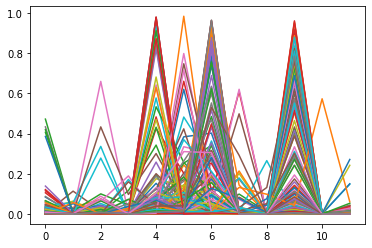

In [40]:
for x in batch_layers_attention:
    plt.plot(range(0, 12), x.numpy().flatten())

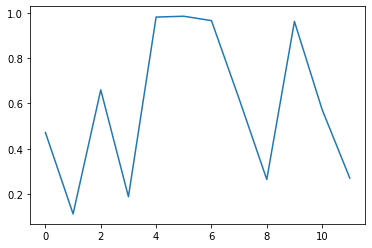

In [43]:
max_layers_attention = torch.max(batch_layers_attention, dim=0)
plt.plot(range(0, 12), max_layers_attention.values.numpy())

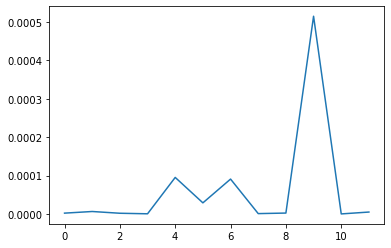

In [44]:
max_layers_attention = torch.min(batch_layers_attention, dim=0)
plt.plot(range(0, 12), max_layers_attention.values.numpy())

# One input test

In [2]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
# change model pretrained path here
model = BertForSequenceClassification.from_pretrained("bert-base-uncased")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [3]:
inputs = tokenizer(["Hello, my dog is cute and I am the biggest person in the world"], 
                   max_length = 128, padding='max_length', truncation=True, return_tensors="pt")
labels = torch.tensor([1]).unsqueeze(0)  # Batch size 1

In [ ]:
model.eval()

In [5]:
outputs = model(**inputs, labels=labels)

In [6]:
model.layer_stop

11

<BarContainer object of 12 artists>

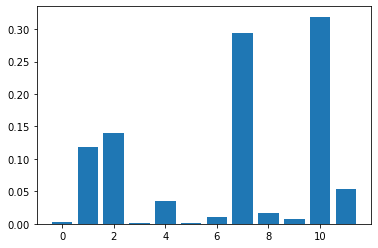

In [7]:
plt.bar(range(0, 12), model.bert.layers_attention.detach().numpy().flatten())